In [1]:
import torch
from pathlib import Path
import numpy as np
from pprint import pprint
import sys
import kilosort

sys.path.append("/Users/yizhan/Documents/Research/HirschLab/Toolbox/SpikeSorting/0-Tools")
import hlab_si
import probeinterface.plotting as pplot


In [2]:
pprint(f"kilosort@{kilosort.__version__}")

if torch.backends.mps.is_available():
    print ("MPS device ready.")
else:
    print ("MPS device not found.")

'kilosort@0.1.0'
MPS device ready.


(<matplotlib.collections.PolyCollection at 0x32a979310>,
 <matplotlib.collections.PolyCollection at 0x32a97a510>)

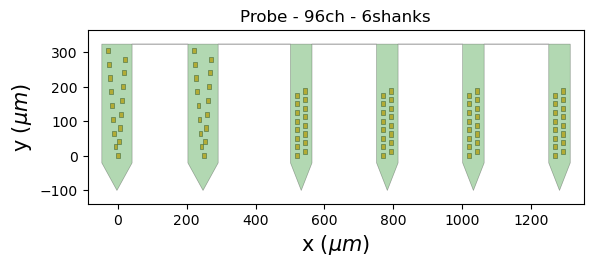

In [3]:
args = {
    'probe': ['E2_10585', 'P2_2615-2']
}

_version = f"{hlab_si.uuidv7()}"

probe_list = [hlab_si.load_hlab_probe(item) for item in args['probe']]
probe = hlab_si.group_probe(probe_list)
pplot.plot_probe(probe)


In [4]:
_setting = {
    ## basic
    "fs": 30000.,
    "n_chan_bin": probe.get_contact_count(),
    # "tmax": 3600*5,

    ## drift correction
    'batch_size': 30000*2,  # second
    'nblocks': 5, # set to 0 for no dirft correction from kilosort

    ## spike detection
    'Th_universal': 9,  # overall detection, default: 9
    'Th_learned': 7,  # detection of learned templates, default: 8

    ## probe related
    # 'dmin': 25,  # vertical spacing
    'dminx': 25,  # horizontal spacing ## probe F: 25
    'min_template_size': 25,  # the sigma of gaussian spatial envelope in microns
    'nearest_chans': 10,  # physical number of channels to generate templates
    'nearest_templates': 16,  # parameter for clustering and learning of templates
    # 'max_channel_distance': 150,
    # 'x_centers': _probe.get_shank_count(),

    ## misc
    # 'artifacts_threshold': 32000,
    # 'artifact_threshold': np.inf,
    # 'artifact_threshold': None,  # typemax(Int16) = 32767 typemin(Int16) = -32768,
    # 'whitening_range': 10,

    'duplicate_spike_ms': 0.5,

    # 'acg_threshold': 0.25,
    # 'ccg_threshold': 0.30,
}

_ks_probe = {
    'chanMap': probe.device_channel_indices.astype('int32'),
    'xc': probe.contact_positions[:, 0].astype("float32"),
    'yc': probe.contact_positions[:, 1].astype("float32"),
    'kcoords': probe.shank_ids.astype("int32"),
    'n_chan': probe.get_contact_count(),
}

In [5]:
workspace = Path("/Users/yizhan/Documents/Research/HirschLab/Toolbox/SpikeSorting/dev/")
data_fpath = workspace / ("./workspace/2025-07-30-R026/2025-07-30-R026.bin")
if not data_fpath.is_file():
    raise(Exception(f"bin file not found: {data_fpath}"))

output_dir = workspace / ("./workspace/2025-07-30-R026") / f'mps-{_version}'
if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [6]:
rez = kilosort.run_kilosort(
                settings=_setting, probe=_ks_probe,
                filename=data_fpath, results_dir=output_dir,
                save_extra_vars=True,
                save_preprocessed_copy=False,
                clear_cache=True,
                data_dtype='int16',
                # shank_idx = shank_index,
                shank_idx = list(range(probe.get_shank_count())),
                device=torch.device('mps')
            )

kilosort.run_kilosort: Kilosort version 0.1.0
kilosort.run_kilosort: Python version 3.11.13
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: macOS-15.6-arm64-arm-64bit arm64
kilosort.run_kilosort: arm
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting [PosixPath('/Users/yizhan/Documents/Research/HirschLab/Toolbox/SpikeSorting/dev/workspace/2025-07-30-R026/2025-07-30-R026.bin')]
kilosort.run_kilosort: clear_cache=True
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage before sorting
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     6.40 %
kilosort.run_kilosort: Mem used:     63.40 %     |      15.22 GB
kilosort.run_kilosort: Mem avail:     8.78 / 24.00 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    N/A
kilosort.run_

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [11]:
import scipy

In [14]:
NT = 30122
b, a = scipy.signal.butter(3, 300, fs=30_000, btype='high')
x = np.zeros(NT)
hp_filter = scipy.signal.filtfilt(b, a , x).copy()

In [16]:
hp_filter.astype("float32")

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)